In [ ]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from numpy.random import randint, normal
from matplotlib import pyplot as plt
import pdb
from torch.distributions.normal import Normal as Normal
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
import torchvision.transforms as transforms
from PIL import Image, ImageDraw, ImageFilter, ImageTransform
import random as rand
import os
import torch.nn.functional as F

#global variables to set size of image
X = 28
Y = 28
BATCH_SIZE = 128

#color dictionary for image generation
COLOR = [
    'white'
]

#make a grey template image
img = np.zeros([X,Y,3],dtype=np.uint8)
img.fill(0) # numpy array!
im = Image.fromarray(img) #convert numpy array to image
im.save('blank.png')

# training images folder
try:
    os.makedirs("train_imgs")
    os.makedirs("train_imgs/rect")
    os.makedirs("train_imgs/tri")
    os.makedirs("train_imgs/circ")
except:
    print("Train folders already exist.")

# testing images folder
try:
    os.makedirs("test_imgs")
    os.makedirs("test_imgs/rect")
    os.makedirs("test_imgs/tri")
    os.makedirs("test_imgs/circ")
except:
    print("Test folders already exist.")

# validation images folder
try:
    os.makedirs("val_imgs")
    os.makedirs("val_imgs/rect")
    os.makedirs("val_imgs/tri")
    os.makedirs("val_imgs/circ")
except:
    print("Validation folders already exist.")

In [ ]:
def draw_rect(im):
    """
    Draw a rectangle on an image
    """
    draw = ImageDraw.Draw(im)
    len = int(X/4)
    #range of values for co-ordinates
    x_min = 0
    y_min = 0
    x_max = X - 2*len
    y_max = Y - len
    x = rand.randint(x_min,x_max)
    y = rand.randint(y_min,y_max)
    draw.rectangle(
        [x,y,x+2*len,y+len],
        fill='white'
    )
    return im

def draw_tri(im): 
    """
    Draw a triangle on an image
    """
    draw = ImageDraw.Draw(im)
    len = int(X/2)
    x_min = 0
    y_min = int(len/2)
    x_max = X-len
    y_max = Y
    x = rand.randint(x_min,x_max)
    y = rand.randint(y_min,y_max)
    draw.polygon(
        [(x,y),
            (int(x+len/2),int(y-len/2)),
            (x+len,y)], 
        fill='white'
    )
    return im

def draw_circ(im): 
    """
    Draw a circle on an image
    """
    draw = ImageDraw.Draw(im)
    len = int(X/4)
    #bounding box for ellipse
    x_min = 0
    y_min = 0
    x_max = X - len
    y_max = Y - len
    x = rand.randint(x_min,x_max)
    y = rand.randint(y_min,y_max)
    draw.ellipse(
        [x,y,x+len,y+len],fill='white'
        )
    return im

def make_image(num,shape,folder):
    """
    Given an number {num}
    and a shape type {shape}, draw that shape in a 
    random location in a 28x28 image and save it
    as "{shape}_{num}.png"
    """
    with Image.open("blank.png") as im:
        draw = ImageDraw.Draw(im)
        if shape=='rect':
            im = draw_rect(im)
        elif shape=='tri':
            im = draw_tri(im)
        elif shape=='circ':
            im = draw_circ(im)
        # save to png (.convert('L') sets grayscale)
        im = im.convert('L')
        #should be 28x28
        arr = np.asarray(im, dtype="int32" )
        im.save(f"{folder}/{shape}/{num}.png")
        return arr

# make train and test images
for shape in ['rect','tri','circ']:
    for i in range(5000):
        make_image(i,shape,"train_imgs")
        make_image(i,shape,"test_imgs")
        make_image(i,shape,"val_imgs")
        
train_dataset = datasets.ImageFolder(root='train_imgs', transform = transforms.ToTensor())
train_loader = data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)

test_dataset = datasets.ImageFolder(root='test_imgs', transform = transforms.ToTensor())
test_loader = data.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True)

val_dataset = datasets.ImageFolder(root='val_imgs', transform = transforms.ToTensor())
val_loader = data.DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [ ]:
# Get gpu device for training if available otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

WIDTH=600
LATENT=200
IMG_SIZE=28*28

class Encoder(nn.Module):
    """
    Encode x into latent representation
    Enforce this latent distribution with 
    MMD
    """
    def __init__(self):
        super(Encoder, self).__init__()
        self.encode = nn.Sequential(
            nn.Linear(IMG_SIZE,WIDTH),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(WIDTH, WIDTH),
            nn.ReLU(),
            nn.Linear(WIDTH, WIDTH),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(WIDTH,WIDTH),
            nn.ReLU(),
            nn.Linear(WIDTH,WIDTH),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(WIDTH,WIDTH),
            nn.ReLU(),
            nn.Linear(WIDTH,WIDTH),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(WIDTH,LATENT)
        )

    def forward(self, x):
        x = self.encode(x)
        return x

class Decoder(nn.Module):
    """
    Take encoding from latent space
    Use this to reconstruct x_hat
    """
    def __init__(self):
        super(Decoder, self).__init__()
        self.decode = nn.Sequential(
            nn.Linear(LATENT,WIDTH),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(WIDTH,WIDTH),
            nn.ReLU(),
            nn.Linear(WIDTH,WIDTH),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(WIDTH,WIDTH),
            nn.ReLU(),
            nn.Linear(WIDTH,WIDTH),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(WIDTH,WIDTH),
            nn.ReLU(),
            nn.Linear(WIDTH,WIDTH),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(WIDTH,IMG_SIZE),
            nn.Tanh()
        )

    def forward(self, sample):
        x_hat = self.decode(sample)
        return x_hat

class AutoEncoder(nn.Module):
    """
    take x and generate x'
    """
    def __init__(self, encoder, decoder):
        super(AutoEncoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        latent = encoder(x)
        # Add gaussian noise of a fixed variance
        eps = torch.normal(0, 0.2, size=latent.shape).to(device)
        #decide not to add gaussian noise for now
        noisy_latent = latent #+ eps
        x_hat = decoder(noisy_latent)
        return x_hat,latent

encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = AutoEncoder(encoder, decoder).to(device)
print("AutoEncoder PyTorch Architecture:")
print(model)

#define optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Using cuda device
AutoEncoder PyTorch Architecture:
AutoEncoder(
  (encoder): Encoder(
    (encode): Sequential(
      (0): Linear(in_features=784, out_features=600, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=600, out_features=600, bias=True)
      (4): ReLU()
      (5): Linear(in_features=600, out_features=600, bias=True)
      (6): ReLU()
      (7): Dropout(p=0.1, inplace=False)
      (8): Linear(in_features=600, out_features=600, bias=True)
      (9): ReLU()
      (10): Linear(in_features=600, out_features=600, bias=True)
      (11): ReLU()
      (12): Dropout(p=0.1, inplace=False)
      (13): Linear(in_features=600, out_features=600, bias=True)
      (14): ReLU()
      (15): Linear(in_features=600, out_features=600, bias=True)
      (16): ReLU()
      (17): Dropout(p=0.1, inplace=False)
      (18): Linear(in_features=600, out_features=200, bias=True)
    )
  )
  (decoder): Decoder(
    (decode): Sequential(
      (0): Linear(

In [ ]:
def calc_loss(x, x_hat, latent):
    """
    Using MSE(x,x') for the reconstruction loss
    and MMD(latent, s ~ N(0,I)) for the regularization loss,
    calculate the overall loss
    """

    # reconstruction loss
    MSE_loss = torch.nn.functional.mse_loss(x, x_hat)

    # regularization loss - use MMD.
    # sample p(z) ~ N(0,I)
    pz_samples = torch.normal(0, 1, size=latent.shape).to(device)
    MMD_loss = MMD(latent, pz_samples)

    loss = MSE_loss + MMD_loss
    return MSE_loss, MMD_loss, loss

"""
Code for MMD loss taken from 
https://github.com/Saswatm123/MMD-VAE/blob/master/MMD_VAE.ipynb
"""

def gaussian_kernel(a, b):
    dim1_1, dim1_2 = a.shape[0], b.shape[0]
    depth = a.shape[1]
    a = a.view(dim1_1, 1, depth)
    b = b.view(1, dim1_2, depth)
    a_core = a.expand(dim1_1, dim1_2, depth)
    b_core = b.expand(dim1_1, dim1_2, depth)
    numerator = (a_core - b_core).pow(2).mean(2)/depth
    return torch.exp(-numerator)

def MMD(a, b):
    return gaussian_kernel(a, a).mean() + gaussian_kernel(b, b).mean() - 2*gaussian_kernel(a, b).mean()

def train(dataloader, model, optimizer):
    size = len(dataloader.dataset)
    model.train()
    history = []
    for batch, (x,y) in enumerate(dataloader):
        x = x.view(-1,IMG_SIZE).to(device)
        # reset gradients to zero because by default we accumulate gradient 
        optimizer.zero_grad()

        x_hat, latent = model.forward(x)

        MSE_loss, MMD_loss, loss = calc_loss(x, x_hat, latent)

        # Backpropagation block
        # compute gradient of loss function using backprop
        loss.backward()
        # update parameters based on calculated gradient
        optimizer.step()

        if batch % 1000 == 0:
            loss, current = loss.item(), batch * len(x)
            history.append(loss)
            print(f"MSE {MSE_loss:>7f} MMD {MMD_loss:>7f} loss: {loss:>7f}")

    return history

def test_loss(dataloader, model):
    """
    Compute loss of a model on some data
    """
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss=0
    with torch.no_grad():
        for x, y in dataloader:
            x = x.view(-1,28*28).to(device)
            x_hat, latent = model(x)
            # Compute loss
            MSE_loss, MMD_loss, loss = calc_loss(x, x_hat, latent)
            test_loss += loss.item()
    test_loss /= num_batches
    return test_loss

In [ ]:
"""
Train the model
Store training and validation loss and accuracy along the way
"""
epochs = 80
train_losses = []
val_losses = []
#initial val loss
val_loss = test_loss(val_loader, model)
val_losses.append(val_loss)
#initial training loss
train_loss = test_loss(train_loader, model)
train_losses.append([train_loss])
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    t_loss = train(train_loader, model, optimizer)
    train_losses.append(t_loss)
    v_loss = test_loss(val_loader, model)
    val_losses.append(v_loss)
print("Done!")
# PLOT LOSS
t_loss = np.ravel([l[0] for l in train_losses])
v_loss = np.ravel(val_losses)

#x scaling to plot diff sized arrays on same plot
x_t = np.linspace(0, epochs, len(t_loss))
x_v = np.linspace(0, epochs, len(v_loss))

print(t_loss)
print(x_t)

fig = plt.figure(figsize=(8, 6), dpi=100)
plt.plot(x_t, t_loss,label="training")
plt.plot(x_v, v_loss,label="validation")
plt.yscale("log")
plt.title("Loss over time (log scale)")
plt.ylabel("Log loss")
plt.xlabel("Epochs")
plt.legend()
plt.savefig('log_loss.png')
plt.show()

Epoch 1
-------------------------------
MSE 0.100574 MMD 0.000055 loss: 0.100629
Epoch 2
-------------------------------
MSE 0.084035 MMD 0.000053 loss: 0.084088
Epoch 3
-------------------------------
MSE 0.085566 MMD 0.000048 loss: 0.085614
Epoch 4
-------------------------------
MSE 0.081930 MMD 0.000051 loss: 0.081981
Epoch 5
-------------------------------
MSE 0.071932 MMD 0.000059 loss: 0.071992
Epoch 6
-------------------------------
MSE 0.058904 MMD 0.000098 loss: 0.059002
Epoch 7
-------------------------------
MSE 0.055770 MMD 0.000135 loss: 0.055905
Epoch 8
-------------------------------
MSE 0.050202 MMD 0.000059 loss: 0.050261
Epoch 9
-------------------------------
MSE 0.038253 MMD 0.000057 loss: 0.038310
Epoch 10
-------------------------------
MSE 0.034460 MMD 0.000064 loss: 0.034523
Epoch 11
-------------------------------
MSE 0.030063 MMD 0.000048 loss: 0.030111
Epoch 12
-------------------------------
MSE 0.028357 MMD 0.000248 loss: 0.028605
Epoch 13
----------------

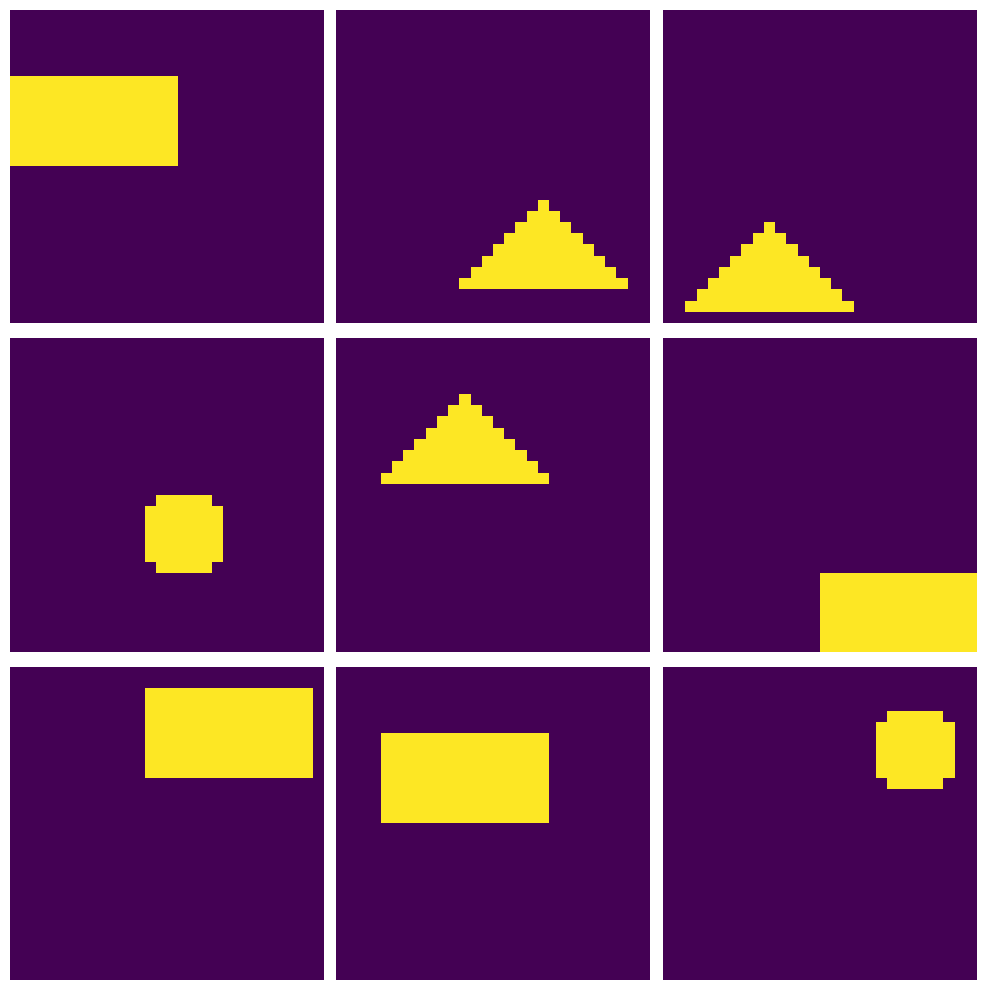

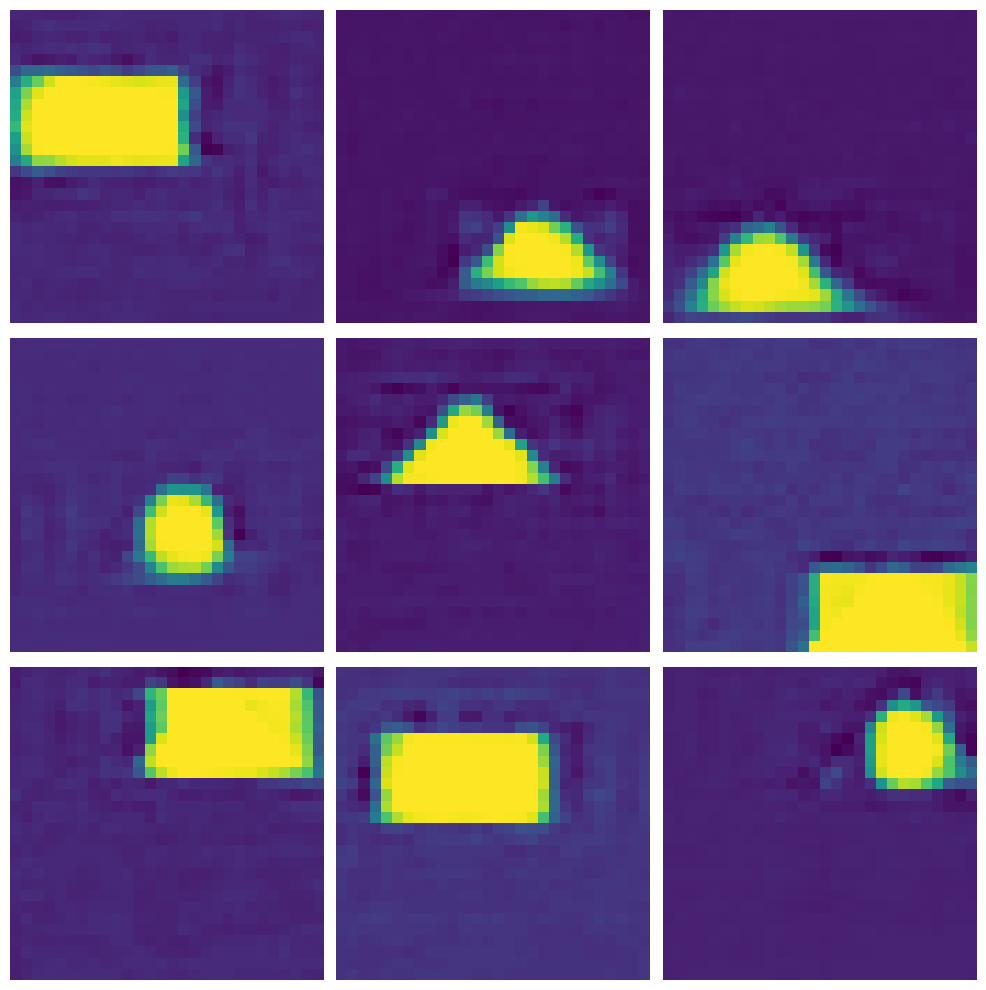

In [ ]:
# redo with batch size = 1 for easy plotting
test_dataset = datasets.ImageFolder(root='test_imgs', transform = transforms.ToTensor())
test_loader = data.DataLoader(test_dataset, batch_size = 1, shuffle = True)
size=3
cords=[
    [0,0],[0,1],[0,2],
    [1,0],[1,1],[1,2],
    [2,0],[2,1],[2,2]
]

preds = []

fig, ax_arr = plt.subplots(size, size, figsize=(10, 10), dpi=100)

# PLOT REAL IMAGES

model.eval()
with torch.no_grad():

    for batch, (x, y) in enumerate(test_loader):
        grid_spot = cords[batch]
        ax_cur = ax_arr[grid_spot[0],grid_spot[1]]
        x = x.squeeze()
        #just grab first shape
        x = x[(batch % 3),:,:].squeeze()
        ax_cur.imshow(x.reshape(28,28))
        ax_cur.axis('off')
        #our pred_dist is a weighting of how much it thinks each rotation is likely, 3 long
        x_hat, _ = model(x.to(device).view(-1,28*28))
        preds.append(x_hat)
        if batch == (size*size-1):
            break

    plt.axis('off')
    plt.tight_layout()
    plt.savefig(
        'original.png',
        bbox_inches='tight'
    )

    #PLOT RECONSTRUCTED IMAGES

    fig, ax_arr = plt.subplots(size, size, figsize=(10, 10), dpi=100)

    for i, x_hat in enumerate(preds):
        grid_spot = cords[i]
        ax_cur = ax_arr[grid_spot[0],grid_spot[1]]
        ax_cur.imshow(x_hat.cpu().numpy().reshape(28,28))
        ax_cur.axis('off')
    
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('processed.png')
    plt.show()

# Try to generate some from scratch

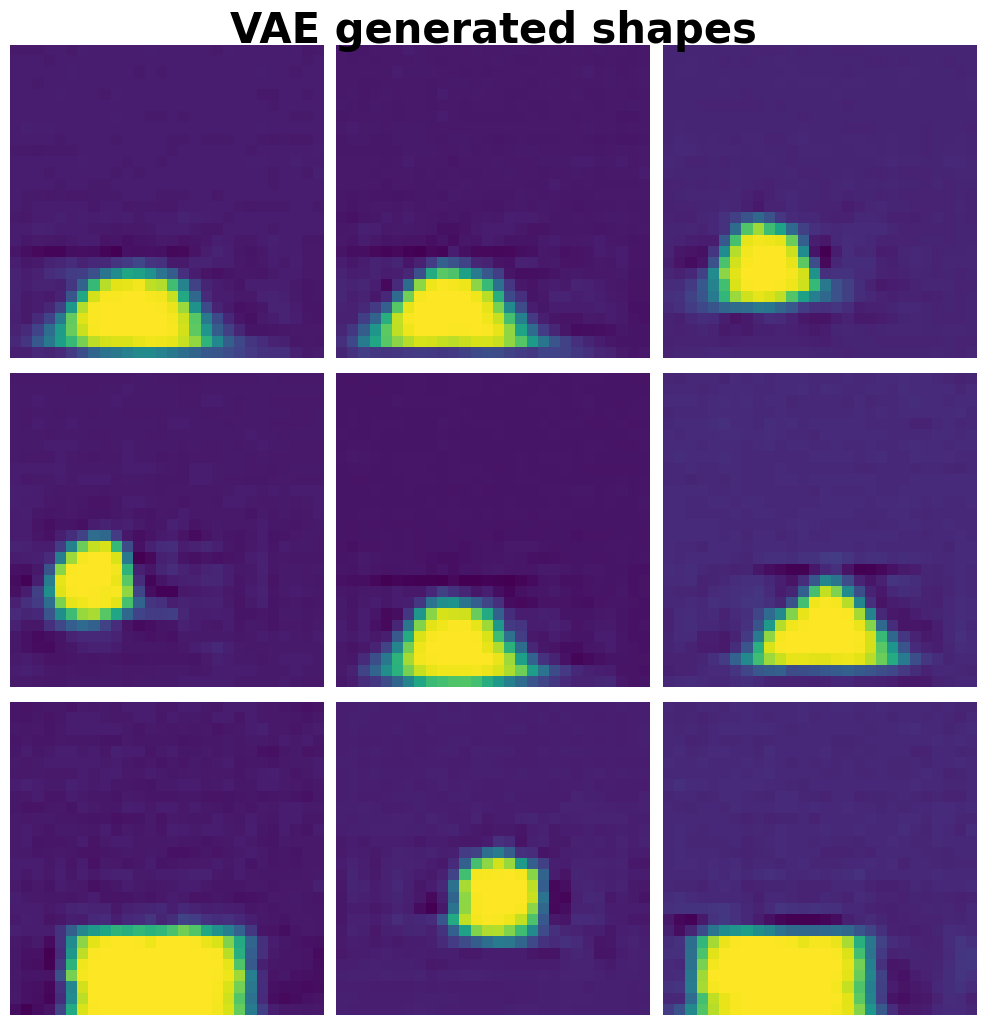

In [ ]:
size=3
cords=[
    [0,0],[0,1],[0,2],
    [1,0],[1,1],[1,2],
    [2,0],[2,1],[2,2]
]

preds = []

#number of samples we want to generate
NUM=9

#shape we sample from
IMG=784

# PLOT REAL IMAGES

model.eval()
with torch.no_grad():

    for i in range(NUM):
        x = torch.normal(0, 2, size=[IMG]).to(device)
        x_hat, _ = model(x)
        preds.append(x_hat)
        if i == (size*size-1):
            break

    #PLOT RECONSTRUCTED IMAGES

    fig, ax_arr = plt.subplots(size, size, figsize=(10, 10), dpi=100)

    for i, x_hat in enumerate(preds):
        grid_spot = cords[i]
        ax_cur = ax_arr[grid_spot[0],grid_spot[1]]
        ax_cur.imshow(x_hat.cpu().numpy().reshape(28,28))
        ax_cur.axis('off')

    fig.suptitle(
        f"VAE generated shapes",
        size=30,
        y=1.02,
        weight='bold'
    )
    
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('generated.png')
    plt.show()